In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import constants as const
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.coordinates import SkyCoord
from astropy import units as u
import csv
import os

pi = np.pi
AU = const.au.value

LAT = np.radians(-30.-(14./60.)-(40.68/3600.))
LONG = np.radians(-70.-(44./60.)-(57.90/3600.))

# Get orbit data

In [2]:
MAINPATH = '/home/devin/Documents/ISOAnalysis-main/iso_data/'
os.chdir(MAINPATH)

NDETECT = len(os.listdir())
NSAMPLES = 100000
NTIMES = 100

SING_KEYS = ['id', 'a', 'e', 'inc', 'Omega', 'omega', 'f', 'b']
MULTI_KEYS = ['time', 'year', 'month', 'day', 'sid_time', 'ra', 'dec', \
             'az', 'alt', 'ra_sun', 'dec_sun', 'az_sun', 'alt_sun', \
             'x', 'y', 'z', 'vx', 'vy', 'vz', 'mag']

In [3]:
def get_key(keyname):
    in_sing_keys = keyname in SING_KEYS
    if in_sing_keys:
        ind = SING_KEYS.index(keyname)
        key = np.zeros(NDETECT)
    else:
        ind = MULTI_KEYS.index(keyname)
        key = np.zeros((NDETECT, NTIMES))
        
    for i, file in enumerate(os.listdir()):
        file_path = MAINPATH + 'particle_' + str(i) + '.csv'
        with open(file_path, 'r') as infile:
            reader = csv.reader(infile)
            rows = list(reader)
            if in_sing_keys:
                key[i] = rows[1][ind]
            else:
                key[i] = np.array(rows[4:])[:, ind]        
    return key

orbits = {}
for key in np.concatenate((SING_KEYS, MULTI_KEYS)):
    orbits[key] = get_key(key)

In [4]:
orbits['datetime'] = np.dstack((orbits['year'], orbits['month'], \
                                    orbits['day']))
orbits['pos_eq'] = np.dstack((orbits['ra'], orbits['dec']))
orbits['pos_horiz'] = np.dstack((orbits['az'], orbits['alt']))
orbits['solar_pos_eq'] = np.dstack((orbits['ra_sun'], orbits['dec_sun']))
orbits['solar_pos_horiz'] = np.dstack((orbits['az_sun'], orbits['alt_sun']))
orbits['rad'] = np.dstack((orbits['x'], orbits['y'], orbits['z']))
orbits['vel'] = np.dstack((orbits['vx'], orbits['vy'], orbits['vz']))

In [5]:
os.chdir('/home/devin/Documents/ISOAnalysis-main/')

In [6]:
def plot_cdf(arr, name=None, xlabel=None, color=None):
    x = np.sort(np.squeeze(arr))
    plt.plot(x, np.linspace(0, 1, len(arr)), lw=2, c=color)
    
    plt.xlabel(xlabel)
    plt.xlim(min(x), max(x))
    
    plt.ylabel(r'$cdf$')
    plt.ylim(0, 1)
    
    if name is not None:
        plt.savefig('figures/' + name + '.pdf', bbox_inches='tight', \
                    dpi=250)
    
    plt.show()
    
def plot_hist(data, bins='auto', c=None, label=None, alpha=0.65, \
              lw=2.5, histtype='step', weights=None, name=None, \
             xlim=None):
    plt.hist(data, bins=bins, color=c, alpha=alpha, label=label, \
             weights=weights)
    plt.hist(data, bins=bins, edgecolor=c, fill=None, \
             histtype=histtype, lw=lw, label=label, weights=weights)
    plt.xlabel(label)
    plt.ylabel(r'$N$')
    
    if xlim is not None:
        plt.xlim(xlim)
    
    if name is not None:
        plt.savefig('figures/' + name + '.pdf', bbox_inches='tight', \
                    dpi=250)
        
    plt.show()

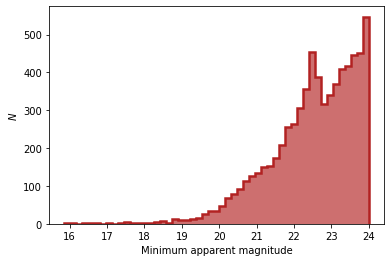

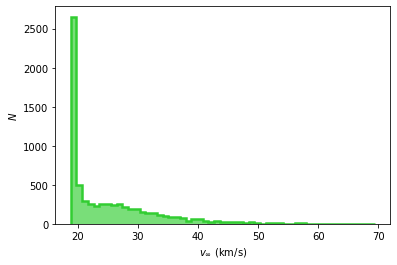

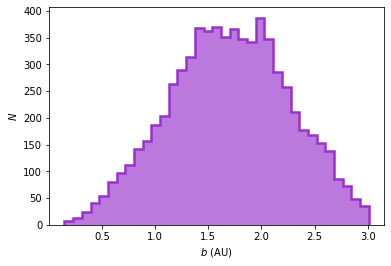

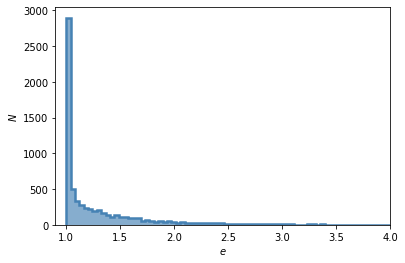

In [7]:
min_mag = np.min(orbits['mag'], axis=1)
v_init = np.linalg.norm(orbits['vel'][:, 0], axis=1)*AU/1000.

plot_hist(min_mag, c='firebrick', label='Minimum apparent magnitude', \
          name='min_mag_hist')
plot_hist(v_init, label=r'$v_{\infty}$ (km/s)', name='v_init_hist', \
         c='limegreen')
plot_hist(orbits['b'], label=r'$b$ (AU)', name='b_hist', \
         c='darkorchid')
plot_hist(orbits['e'], label=r'$e$', name='e_hist', c='steelblue', \
         xlim=(0.9, 4))

In [8]:
detectable = (orbits['mag'] <= 24)*(orbits['pos_horiz'][:, :, 1] > np.radians(30.))*(orbits['solar_pos_horiz'][:, :, 1] < np.radians(-18.))
detectable = np.any(detectable==True, axis=1)
nobs = len(detectable[detectable==True])
        
print('Detections: %d' %nobs)
print('Detection rate: %.3f %%' %(nobs/NSAMPLES*100))

Detections: 2470
Detection rate: 2.470 %


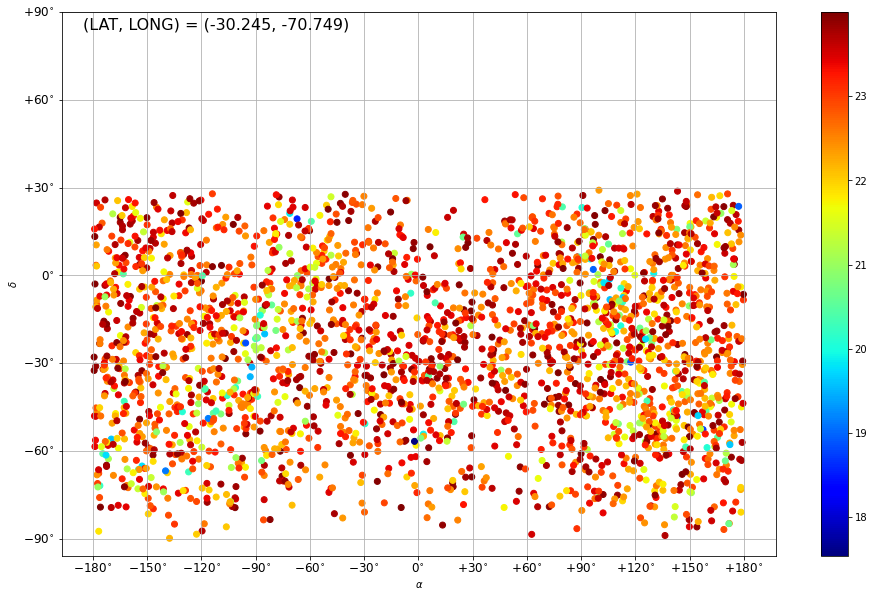

In [9]:
det_pos = []
det_mag = []
for i in range(NDETECT):
    det = (orbits['mag'][i] <= 24.)*\
            (orbits['pos_horiz'][i][:, 1] > np.radians(30.))*\
            (orbits['solar_pos_horiz'][i][:, 1] < np.radians(-18.))
    if True in det:
        j = np.where(orbits['mag'][i][det] == np.min(orbits['mag'][i][det]))
        det_pos.append(orbits['pos_eq'][i][det][j])
        det_mag.append(orbits['mag'][i][det][j])
            
det_pos = np.reshape(det_pos, (nobs, 2))
det_mag = np.reshape(det_mag, nobs)
    
plt.figure(figsize=(16, 10))
plt.scatter(det_pos[:, 0], det_pos[:, 1], c=det_mag, cmap='jet')

plt.xlabel(r'$\alpha$')
plt.xticks([-pi, -5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi], [r'$-180^{\circ}$', \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$', r'$+180^{\circ}$'], \
          fontsize=12)

plt.ylabel(r'$\delta$')
plt.yticks([-pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2], [r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', \
        r'$0^{\circ}$', r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$'], fontsize=12)
plt.grid(True)
plt.colorbar()

plt.text(-pi-0.1, pi/2-0.1, '(LAT, LONG) = (%.3f, %.3f)' %(np.degrees(LAT), \
            np.degrees(LONG)), fontsize=16)

plt.savefig('figures/detectable_pos.pdf', bbox_inches='tight', dpi=250)
plt.show()

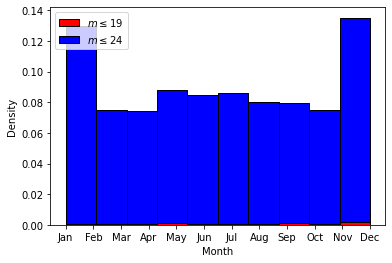

In [10]:
min_mag_month = np.zeros(NDETECT)
for i in range(NDETECT):
    min_mag_month[i] = orbits['datetime'][i][orbits['mag'][i] == \
                                    min_mag[i]].flatten()[1]

c = ['red', 'blue']
plt.hist([min_mag_month[min_mag <= 19.], min_mag_month[min_mag <= 24.]], \
         stacked=True, color=c, edgecolor='k', density=True, \
        label=[r'$m\leq 19$', r'$m\leq 24$'])

plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', \
                             'May', 'Jun', 'Jul', 'Aug', 'Sep', \
                              'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.savefig('figures/month_detect.pdf', bbox_inches='tight', dpi=250)
plt.show()